In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1YYcPg4eT9CKR1X3DkYoZdokc24oWyakw' # The shareable link
fluff, id = link.split('=')

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ASX200Daily.csv')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

In [0]:
# Reading data
daily_data = pd.read_csv('ASX200Daily.csv')

In [6]:
# Converting to a time series
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data.set_index('Date', inplace = True)
daily_ts = pd.Series(daily_data['Close'])
print(daily_ts.head())

Date
2000-03-31    3133.300049
2000-04-03    3191.000000
2000-04-04    3176.800049
2000-04-05    3155.399902
2000-04-06    3157.100098
Name: Close, dtype: float64


In [0]:
# Removing missing values
daily_ts.dropna(inplace=True)

In [0]:
# Days of the week with closing price given
daily_ts.index.dayofweek.unique()

Int64Index([4, 0, 1, 2, 3, 6], dtype='int64', name='Date')

In [0]:
# Removing rows with day of the week = 6 (Sunday)
# Only taking weekdays into account will give better predictions for this assignment
daily_ts = daily_ts[daily_ts.index.dayofweek!=6]

In [0]:
# Splitting data into training and validation subsets
training_subset = daily_ts[:-365]
validation_subset = daily_ts[-365:]

### Holt's Linear Method

In [0]:
holts_linear = Holt(training_subset).fit()
training_ts = holts_linear.fittedvalues
holts_linear.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'damping_slope': nan,
 'initial_level': 3135.712285981564,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 0.6515542691483723,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9457932752276673,
 'smoothing_seasonal': nan,
 'smoothing_slope': 0.0,
 'use_boxcox': False}

In [0]:
# Forecasting values of next 365 days
predictions = holts_linear.forecast(365)
predictions.index = validation_subset.index

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


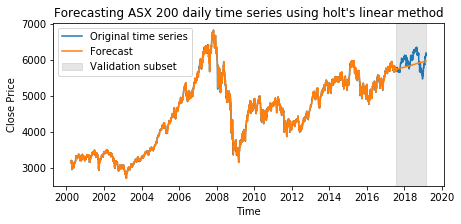

In [0]:
predicted_ts = training_ts.append(predictions)

# Setting figure width and height
rcParams['figure.figsize'] = 15, 7

plt.plot(daily_ts, label = "Original time series")
plt.plot(predicted_ts, label = "Forecast")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title("Forecasting ASX 200 daily time series using holt's linear method")
plt.legend()

In [0]:
# Measuring errors of training subset
RMSE = np.sqrt(mean_squared_error(training_subset, training_ts))
MAE = mean_absolute_error(training_subset, training_ts)
MAPE = np.mean(np.abs((training_subset - training_ts) / training_subset)) * 100

print('Training subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset ->
Root Mean Squared Error (RMSE): 48.69351089655005
Mean Absolute Error (MAE): 33.332486271527486
Mean Absolute Percentage Error (MAPE): 0.7318957742876162


In [0]:
# Measuring errors of validation subset
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions))
MAE = mean_absolute_error(validation_subset, predictions)
MAPE = np.mean(np.abs((validation_subset - predictions) / validation_subset)) * 100

print('Validation subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset ->
Root Mean Squared Error (RMSE): 223.0247586436078
Mean Absolute Error (MAE): 185.59888034669729
Mean Absolute Percentage Error (MAPE): 3.0743899539195265


### Holt-Winters Method

In [0]:
# For additive seasonality
holt_winters_add = ExponentialSmoothing(training_subset, seasonal_periods = 5, trend = 'add', seasonal = 'add').fit()
training_ts_add = holt_winters_add.fittedvalues

# For multiplicative seasonality
holt_winters_mul = ExponentialSmoothing(training_subset, seasonal_periods = 5, trend = 'add', seasonal = 'mul').fit()
training_ts_mul = holt_winters_mul.fittedvalues

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
# Holt-winters additive seasonality parameters
holt_winters_add.params

{'damping_slope': nan,
 'initial_level': 4510.579153181744,
 'initial_seasons': array([-1351.2270196 , -1349.46355786, -1350.6112526 , -1349.1564936 ,
        -1347.69891716]),
 'initial_slope': 0.703068231776134,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9464483690386865,
 'smoothing_seasonal': 0.0024595161367312697,
 'smoothing_slope': 9.684211777462012e-23,
 'use_boxcox': False}

In [0]:
## Holt-winters multiplicative seasonality parameters
holt_winters_mul.params

{'damping_slope': nan,
 'initial_level': 4512.062232463297,
 'initial_seasons': array([0.6948348 , 0.69525066, 0.69478766, 0.695058  , 0.69587191]),
 'initial_slope': 0.00019546240099332603,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9479754554896515,
 'smoothing_seasonal': 0.0025139687556888996,
 'smoothing_slope': 3.5684162872940726e-10,
 'use_boxcox': False}

In [0]:
# Forecasting values of next 365 days

predictions_add = holt_winters_add.forecast(365)
predictions_add.index = validation_subset.index

predictions_mul = holt_winters_mul.forecast(365)
predictions_mul.index = validation_subset.index

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


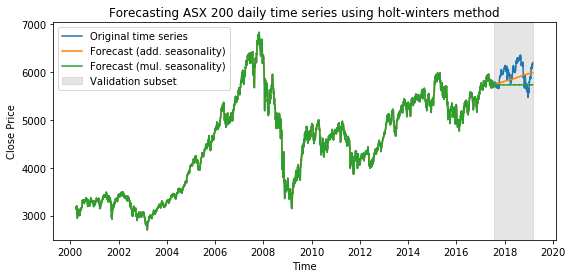

In [0]:
predicted_ts_add = training_ts.append(predictions_add)
predicted_ts_mul = training_ts.append(predictions_mul)

plt.plot(daily_ts, label = "Original time series")
plt.plot(predicted_ts_add, label = "Forecast (add. seasonality)")
plt.plot(predicted_ts_mul, label = "Forecast (mul. seasonality)")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title("Forecasting ASX 200 daily time series using holt-winters method")
plt.legend()

In [0]:
# Measuring errors of training subset (additive seasonality)
RMSE = np.sqrt(mean_squared_error(training_subset, training_ts_add))
MAE = mean_absolute_error(training_subset, training_ts_add)
MAPE = np.mean(np.abs((training_subset - training_ts_add) / training_subset)) * 100

print('Training subset (additive seasonality) ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset (additive seasonality) ->
Root Mean Squared Error (RMSE): 48.66283938917725
Mean Absolute Error (MAE): 33.355056086286176
Mean Absolute Percentage Error (MAPE): 0.7326033389045529


In [0]:
# Measuring errors of validation subset (additive seasonality)
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions_add))
MAE = mean_absolute_error(validation_subset, predictions_add)
MAPE = np.mean(np.abs((validation_subset - predictions_add) / validation_subset)) * 100

print('Validation subset (additive seasonality) ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset (additive seasonality) ->
Root Mean Squared Error (RMSE): 219.0544623333038
Mean Absolute Error (MAE): 182.60904670184894
Mean Absolute Percentage Error (MAPE): 3.028634876951678


In [0]:
# Measuring errors of training subset (multiplicative seasonality)
RMSE = np.sqrt(mean_squared_error(training_subset, training_ts_mul))
MAE = mean_absolute_error(training_subset, training_ts_mul)
MAPE = np.mean(np.abs((training_subset - training_ts_mul) / training_subset)) * 100

print('Training subset (multiplicative seasonality) ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset (multiplicative seasonality) ->
Root Mean Squared Error (RMSE): 48.6378151035839
Mean Absolute Error (MAE): 33.38659216222348
Mean Absolute Percentage Error (MAPE): 0.7332439625889536


In [0]:
# Measuring errors of validation subset (multiplicative seasonality)
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions_mul))
MAE = mean_absolute_error(validation_subset, predictions_mul)
MAPE = np.mean(np.abs((validation_subset - predictions_mul) / validation_subset)) * 100

print('Validation subset (multiplicative seasonality) ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset (multiplicative seasonality) ->
Root Mean Squared Error (RMSE): 305.49007922779356
Mean Absolute Error (MAE): 250.17997259217682
Mean Absolute Percentage Error (MAPE): 4.108433116287578
